# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [1]:
import requests
import time
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re

url = "https://ycharts.com/companies/TSLA/revenues"

# Agregar headers para evitar el error 403
headers = {
    'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"
}

# Petición para descargar el fichero de Internet
response = requests.get(url, headers=headers)
time.sleep(5)  # Pausar 5 segundos para evitar sobrecargar el servidor

# Comprobar si la solicitud fue exitosa
if response.status_code == 200:
    # Parsear el contenido HTML
    soup = BeautifulSoup(response.text, "html.parser")

    # Buscar la tabla
    table = soup.find("table", class_="table")

    # Asegurarse de que la tabla existe
    if table:

        data = pd.DataFrame(columns = ["fecha", "ingreso"])

        # Recorrer todas las filas de la tabla
        for row in table.find_all('tr')[1:]:
            columns = row.find_all('td')
            if len(columns) >= 2:
                fecha = columns[0].text.strip()
                ingreso = columns[1].text.replace("$", "").replace(",", "").strip()
               
                # Limpiar y convertir el ingreso
                if ingreso.endswith("B"):
                    ingreso = float(ingreso.replace("B", "")) * 1e9  # Convertir de billones a número
                else:
                    ingreso = float(ingreso)  # Convertir a float si ya es un número simple
        
                # Agregar la fila al DataFrame usando loc[]
                data.loc[len(data)] = [fecha, ingreso]

        # Filtrar valores vacíos
        data = data[data["ingreso"] != ""]

        # Convertir la columna 'Fecha' a formato datetime
        data['fecha'] = pd.to_datetime(data['fecha'])

        # Filtrar los datos para obtener solo los trimestres desde junio de 2009
        data = data[data['fecha'] >= '2009-06-01']

        # Convertir las fechas a cadenas para evitar el error con el tipo 'Timestamp'
        data['fecha'] = data['fecha'].dt.strftime('%Y-%m-%d')

        # Convertir DataFrame a lista de tuplas
        tesla_tuples = list(data.itertuples(index=False, name=None))

        # Conectar a la base de datos y crear la tabla
        con = sqlite3.connect('tesla.bd')
        cursor = con.cursor()

        cursor.execute('''
        DROP TABLE IF EXISTS Revenue;
         ''')
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Revenue (
                date TEXT,
                revenue REAL
            )
        ''')

        cursor.executemany("INSERT INTO Revenue VALUES (?, ?)", tesla_tuples)
        con.commit()

        # Mostrar los datos insertados
        for row in cursor.execute("SELECT * FROM Revenue"):
            print(row)

        con.close()

    else:
        print("No se encontró la tabla en la página web.")
else:
    print(f"Error al acceder a la página. Código de estado: {response.status_code}")



('2024-06-30', 25500000000.0)
('2024-03-31', 21300000000.0)
('2023-12-31', 25170000000.0)
('2023-09-30', 23350000000.0)
('2023-06-30', 24930000000.0)
('2023-03-31', 23330000000.0)
('2022-12-31', 24320000000.0)
('2022-09-30', 21450000000.0)
('2022-06-30', 16930000000.0)
('2022-03-31', 18760000000.0)
('2021-12-31', 17720000000.0)
('2021-09-30', 13760000000.0)
('2021-06-30', 11960000000.0)
('2021-03-31', 10390000000.0)
('2020-12-31', 10740000000.0)
('2020-09-30', 8771000000.0)
('2020-06-30', 6036000000.0)
('2020-03-31', 5985000000.0)
('2019-12-31', 7384000000.0)
('2019-09-30', 6303000000.0)
('2019-06-30', 6350000000.0)
('2019-03-31', 4541000000.0)
('2018-12-31', 7226000000.0)
('2018-09-30', 6824000000.0)
('2018-06-30', 4002000000.0)


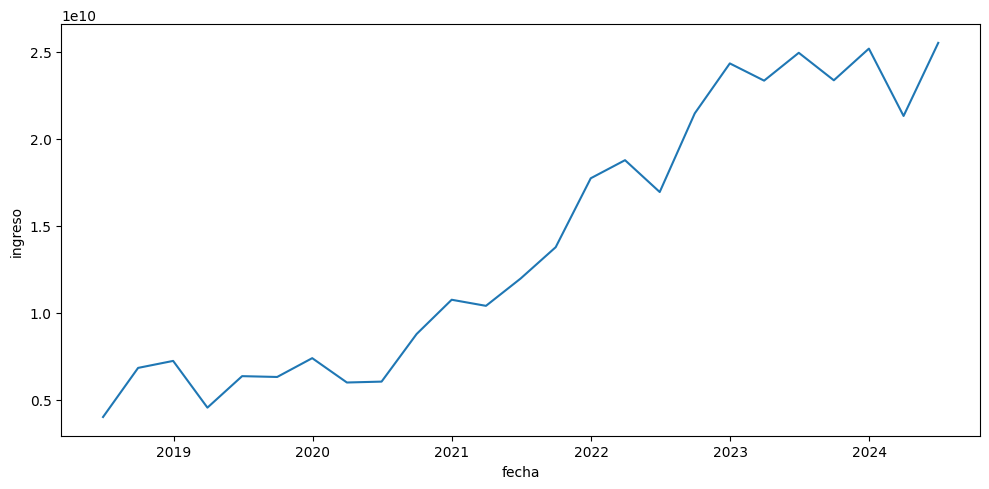

In [2]:
fig, axis = plt.subplots(figsize = (10, 5))
data["fecha"] = pd.to_datetime(data["fecha"])
data["ingreso"] = data["ingreso"]
sns.lineplot(data = data, x = "fecha", y = "ingreso")

plt.tight_layout()

plt.show()

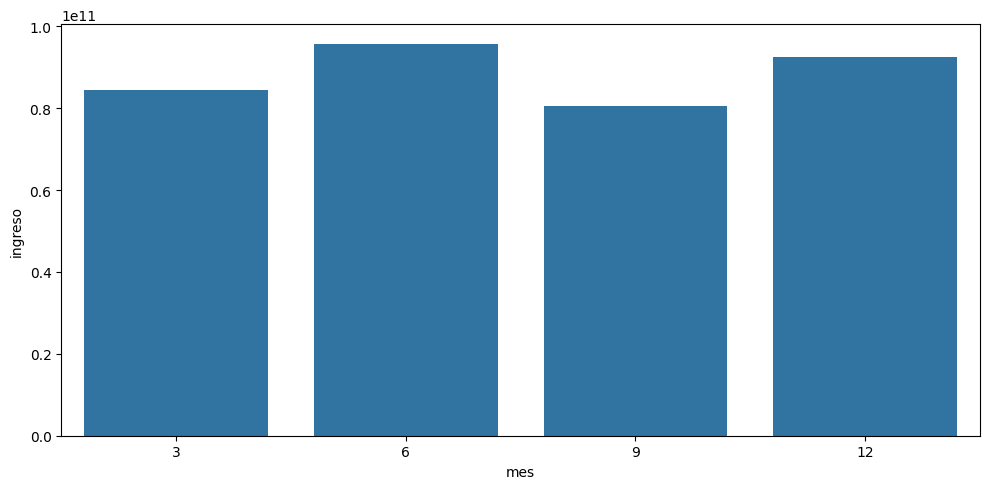

In [7]:
# Asegurarse de que 'fecha' esté en formato datetime
data['fecha'] = pd.to_datetime(data['fecha'])

# Extraer el mes de la columna 'fecha' y agregarlo como una nueva columna
data['mes'] = data['fecha'].dt.month

# Agrupar por mes y sumar los ingresos
tesla_revenue_monthly = data.groupby('mes')['ingreso'].sum().reset_index()

# Crear el gráfico de barras
fig, axis = plt.subplots(figsize=(10, 5))
sns.barplot(data=tesla_revenue_monthly, x="mes", y="ingreso", ax=axis)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

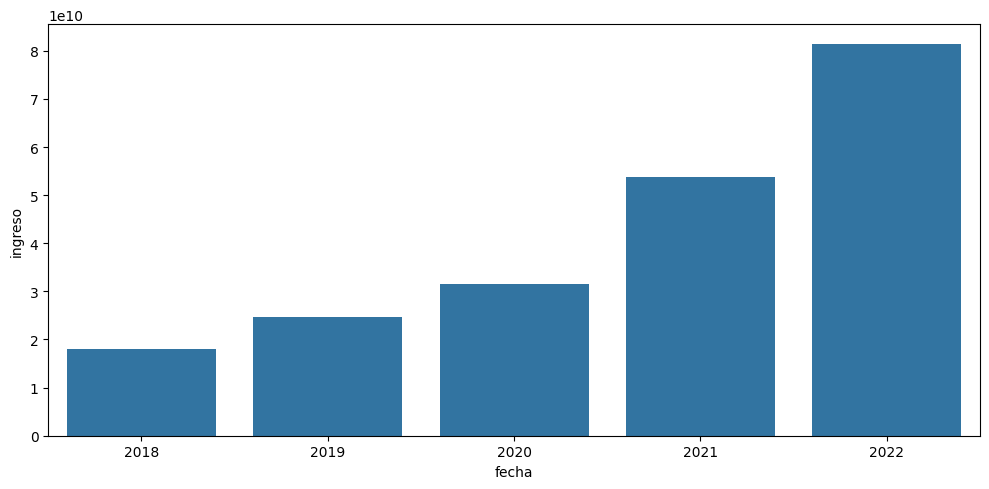

In [8]:
# Asegurarse de que 'fecha' esté en formato datetime
data["fecha"] = pd.to_datetime(data["fecha"])

# Agrupar por año y sumar los ingresos
tesla_revenue_yearly = data.groupby(data["fecha"].dt.year)["ingreso"].sum().reset_index()

# Filtrar los datos para incluir solo los años antes de 2023
tesla_revenue_yearly = tesla_revenue_yearly[tesla_revenue_yearly["fecha"] < 2023]

# Crear el gráfico de barras
fig, axis = plt.subplots(figsize=(10, 5))
sns.barplot(data=tesla_revenue_yearly, x="fecha", y="ingreso", ax=axis)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()